In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# 데이터 로드
df = pd.read_csv('../data/gym_churn_us.csv')

In [4]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# 그리드서치를 위한 하이퍼파라미터
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state=42)

# 그리드서치를 사용한 하이퍼파라미터 분석
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# 최적 파라미터 출력
print("\n=== 최적 하이퍼파라미터 ===")
print(grid_search.best_params_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


c:\Users\Playdata\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1080 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
499 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Playdata\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Playdata\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\Playdata\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\base.py", line 436, in _validate_params
  


=== 최적 하이퍼파라미터 ===
{'class_weight': 'balanced', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [6]:
# 최적 모델을 사용한 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [7]:
# 성능 평가
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [8]:
# 특성 중요도 계산
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

# 결과 출력
print("\n=== 최적화된 모델 성능 평가 ===")
print(f"정확도 (Accuracy): {accuracy:.4f}")
print(f"정밀도 (Precision): {precision:.4f}")
print(f"F1 점수: {f1:.4f}")

print("\n=== 특성 중요도 (상위 5개) ===")
print(feature_importance.head())


=== 최적화된 모델 성능 평가 ===
정확도 (Accuracy): 0.9163
정밀도 (Precision): 0.8358
F1 점수: 0.8337

=== 특성 중요도 (상위 5개) ===
                              feature  importance
10                           Lifetime    0.307297
12  Avg_class_frequency_current_month    0.165515
7                                 Age    0.120870
11          Avg_class_frequency_total    0.108081
9               Month_to_end_contract    0.095203


----

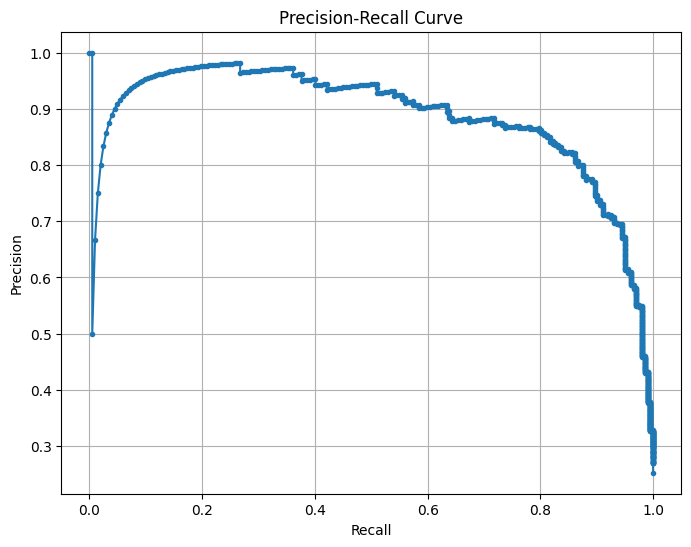

In [18]:
# 정밀도와 재현율간의 관계 시각화
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

**결론**:
- 모델의 정밀도(Precision)는 재현율(Recall)이 낮을 때(1에 가까운 Recall 값) 거의 1에 가까운 값을 유지. -> 모델이 이탈 고객을 잘 예측하고 있음을 나타냄
- 재현율이 증가함에 따라 정밀도는 다소 감소하는 경향이 있지만, 여전히 높은 정밀도를 유지하고 있다. -> 이탈 고객을 잘 찾아내면서도 많은 잘못된 이탈 예측을 하지 않음을 보여줌 

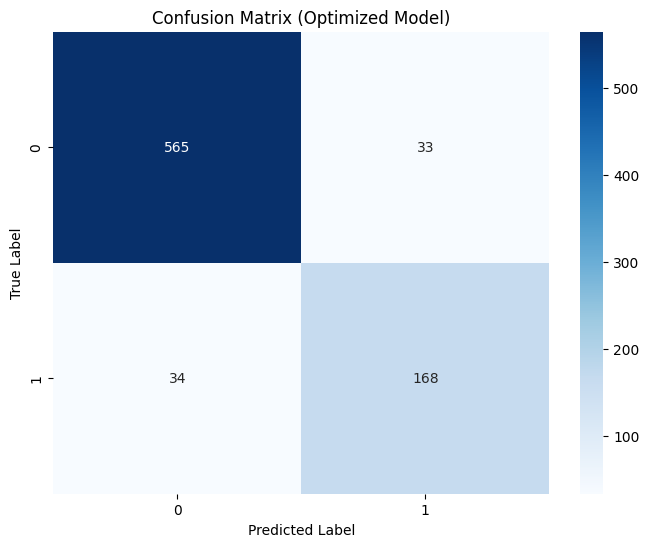

In [13]:
# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Optimized Model)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

**결론**:
- **진짜 음성 (TN)**: 565건 - 모델이 이탈하지 않을 것으로 예측했고 실제로도 이탈하지 않음. -> 모델이 대부분의 음성 샘플을 잘 분류했음
- **거짓 양성 (FP)**: 33건 - 이탈할 것으로 예측했으나 실제로는 이탈하지 않음. -> 모델의 오탐지 비율이 상대적으로 낮음
- **거짓 음성 (FN)**: 34건 - 이탈하지 않을 것으로 예측했으나 실제로 이탈함. -> 이탈 고객을 놓치는 경우가 다소 있음
- **진짜 양성 (TP)**: 168건 - 이탈할 것으로 예측했고 실제로 이탈함. -> 모델이 이탈 고객을 잘 찾아냈음을 나타냄.
- 전반적으로 모델의 성능이 우수하며, 이탈하지 않을 고객과 이탈할 고객을 잘 구분하고 있음을 보여준다.

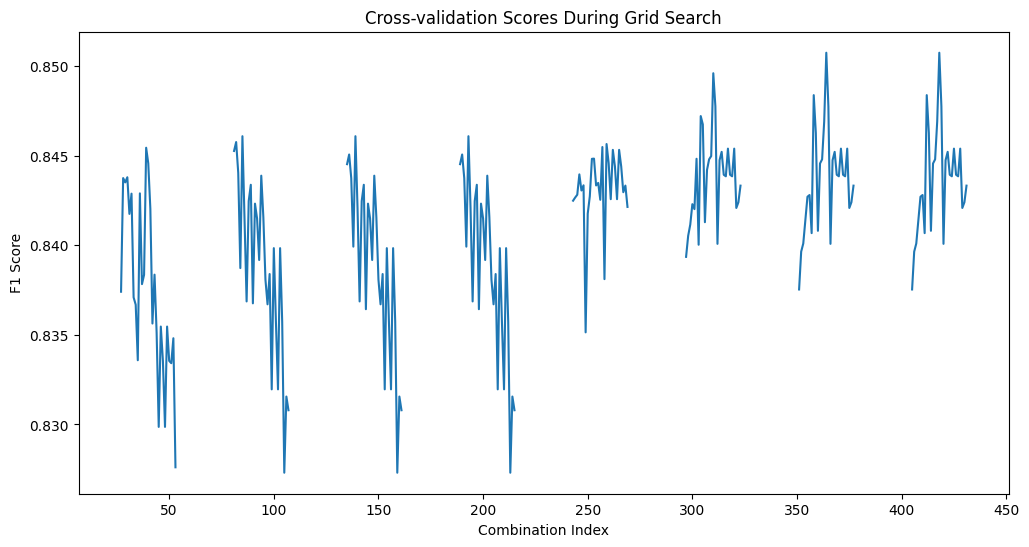

In [14]:
# 교차 검증 결과 시각화
cv_results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(12, 6))
plt.plot(cv_results['mean_test_score'])
plt.title('Cross-validation Scores During Grid Search')
plt.xlabel('Combination Index')
plt.ylabel('F1 Score')
plt.show()

**결론**:
- F1 점수가 다양한 하이퍼파라미터 조합에서 변화하는 모습을 보여준다.
- 점수의 변동성이 있지만, **전반적으로 0.83에서 0.85 사이의 값을 유지**하고 있음.
- 이는 모델이 다양한 하이퍼파라미터 조합에 대해 안정적인 성능을 보인다는 것을 나타낸다. 특히, 특정 조합에서 성능이 뛰어난 점수를 기록하고 있음을 알 수 있음.

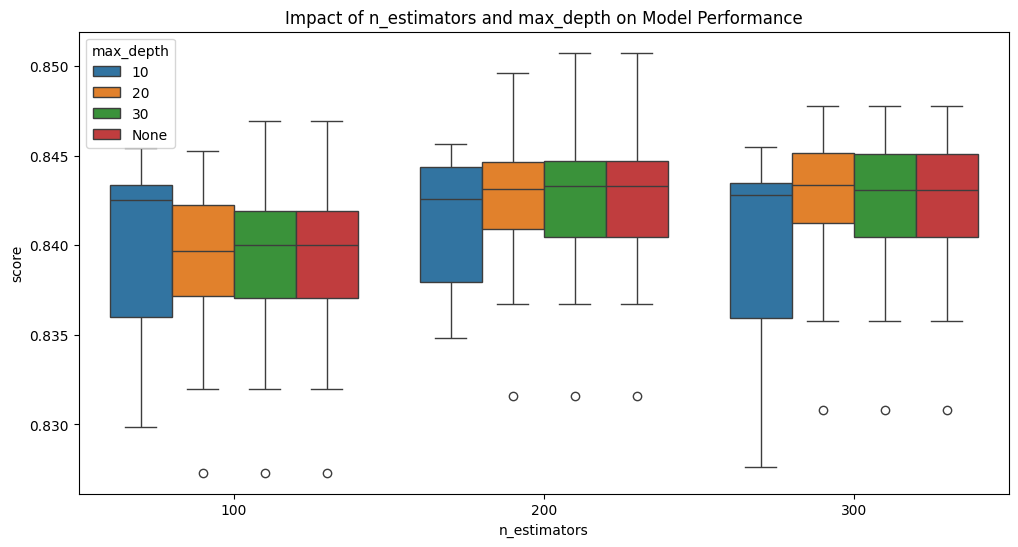

In [15]:
# 중요 하이퍼파라미터의 영향 분석
param_scores = pd.DataFrame({
    'n_estimators': cv_results['param_n_estimators'],
    'max_depth': cv_results['param_max_depth'].astype(str),
    'score': cv_results['mean_test_score']
})

plt.figure(figsize=(12, 6))
sns.boxplot(x='n_estimators', y='score', hue='max_depth', data=param_scores)
plt.title('Impact of n_estimators and max_depth on Model Performance')
plt.show()

**결론**:
- 모델의 성능은 n_estimators와 max_depth에 따라 달라지지만, 성능 차이가 크지 않음.
- max_depth가 10일 때의 성능이 가장 높게 나타나며, 다른 깊이에서도 비슷한 성능을 유지하고 있음.
- 이 결과는 **모델이 복잡한 구조를 가지지 않고도 높은 성능을 낼 수 있다**는 것을 보여준다.

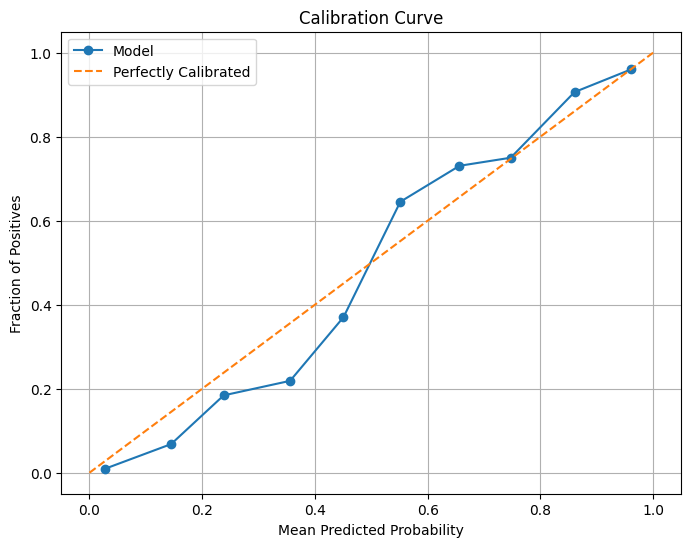

In [19]:
# Calibration Curve - 모델의 예측 확률이 실제 클래스 확률과 얼마나 잘 일치하나
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid()
plt.show()


**결론**:
- 모델의 예측이 잘 보정(calibrated)되었음을 나타내며, 예측 확률이 높을수록 실제 양성 비율도 증가
- 그래프가 대각선(Perfectly Calibrated)에 가까울수록 모델의 예측이 신뢰할 수 있음을 의미
- 이 경우, 모델의 예측이 비교적 잘 보정되어 있지만, 예측 확률이 0.5 이하일 때와 0.9 이상일 때 실제 양성 비율이 다소 떨어지는 경향이 있다. 이는 특정 구간에서 모델의 신뢰도를 향상시킬 여지가 있음을 시사.

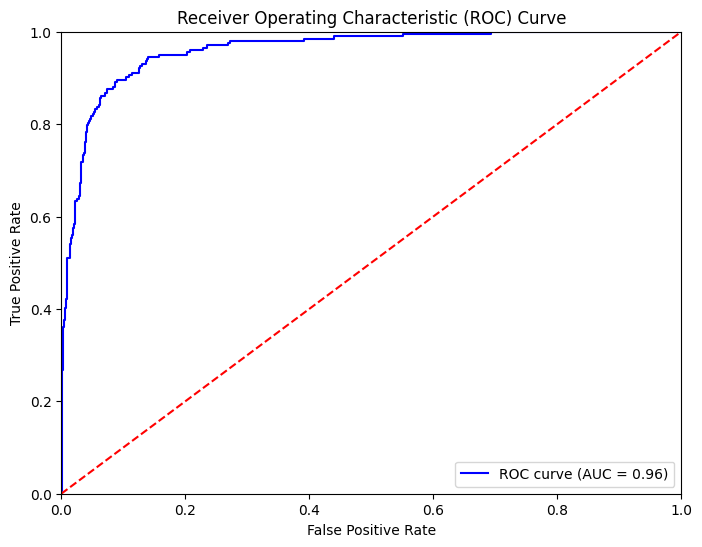

In [16]:
from sklearn.metrics import roc_curve, auc

# 예측 확률 계산
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# ROC 곡선 데이터 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ROC 커브 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # 대각선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**결론**
- 모델 성능: **AUC 값이 0.96인 경우, 모델의 분류 성능이 매우 우수**. 이는 모델이 실제 양성 사례를 잘 식별하고, 잘못된 양성 예측을 최소화하고 있음을 보여줌.
- 신뢰성: 이 정도의 AUC 값은 일반적으로 신뢰할 수 있는 예측을 제공하며, 비즈니스 또는 연구 목적에 맞게 모델을 활용할 수 있는 좋은 기준이 된다.
- 의사결정 지원: 이러한 성능 지표는 향후 고객 이탈 예측 또는 기타 분류 문제 상황에서 모델의 신뢰성을 높이고, 의사결정 과정을 지원하는 데 중요한 역할을 할 수 있음.

----

## 결론

1. **모델 성능 분석**:
- 혼동 행렬(Confusion Matrix)을 보면:
    - 진짜 음성(TN): 565건 (이탈하지 않을 것으로 예측했고 실제로 이탈하지 않음)
    - 거짓 양성(FP): 33건 (이탈할 것으로 예측했으나 실제로 이탈하지 않음)
    - 거짓 음성(FN): 34건 (이탈하지 않을 것으로 예측했으나 실제로 이탈함)
    - 진짜 양성(TP): 168건 (이탈할 것으로 예측했고 실제로 이탈함)

- 모델 성능 지표:
    - 정확도 91.63%: 전체 예측 중 약 92%가 정확함
    - 정밀도 83.58%: 이탈 예측 중 실제 이탈한 비율
    - F1 점수 83.37%: 정밀도와 재현율의 조화평균으로 양호한 수준

2. **하이퍼파라미터 최적화 결과**:
- n_estimators(트리 개수)와 max_depth(트리 깊이)에 따른 성능 변화를 보여줌
- 200~300개의 트리와 다양한 깊이에서 비슷한 성능을 보임
- 성능 차이가 크지 않아 간단한 모델(낮은 깊이)로도 충분한 성능 달성 가능

3. **특성 중요도 분석**:
- Lifetime(고객 생애 기간): 30.7%로 가장 중요
- 현재 월 평균 수업 빈도: 16.6%로 두 번째로 중요
- 나이: 12.1%
- 전체 평균 수업 빈도: 10.8%
- 계약 종료까지 남은 기간: 9.5%

4. **ROC 곡선 및 AUC 분석**:
- ROC 곡선은 모델이 양성과 음성을 잘 구분하고 있음. (곡선이 왼쪽 위 코너에 가까워질수록 모델의 성능이 우수함)
- AUC 값이 0.96으로 매우 높아, 모델이 96%의 확률로 양성과 음성을 구분할 수 있음을 보여줌. -> 모델의 분류 성능이 뛰어나며 신뢰할 수 있는 예측을 제공한다는 것을 의미.

#### **최종 결론**:

- 모델의 예측 성능이 전반적으로 우수하며, 특히 91.63%의 높은 정확도를 보임
- 고객 이탈 예측에 있어 고객의 생애 기간과 수업 참여도가 가장 중요한 지표
- 하이퍼파라미터 튜닝 결과, 복잡한 모델이 아니어도 충분한 성능을 낼 수 있음
- ROC 곡선과 AUC 분석 결과, 모델의 분류 성능이 매우 뛰어나며, 신뢰할 수 있는 예측을 제공함
- 실제 활용을 위해서는 특히 고객의 생애 기간과 수업 참여도를 중점적으로 모니터링하고, 이탈 위험이 있는 고객들에 대한 선제적 관리가 필요